In [1]:
# 设置使用第二块 GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"


In [2]:
import yaml
from dataclasses import dataclass
from typing import List

@dataclass
class MaskConfig:
    model: str
    attn_heads: int = 0
    mlps: int = 0

@dataclass
class DataConfig:
    seed: int
    name: str
    path: str
    workers: int
    val_size: float

@dataclass
class TrainerConfig:
    epochs: int
    lr: float
    momentum: float
    weight_decay: float
    batch_size: int
    checkpoint_path: str
    results_path: str

@dataclass
class DiffMaskConfig:
    seed: int
    mask: MaskConfig
    data: DataConfig
    trainer: TrainerConfig

# 读取 YAML 配置文件
with open('diffmask.yaml', 'r') as file:
    config_data = yaml.safe_load(file)

# 初始化配置对象
config_data['trainer']['lr'] = float(config_data['trainer']['lr'])
config_data['trainer']['momentum'] = float(config_data['trainer']['momentum'])
config_data['trainer']['weight_decay'] = float(config_data['trainer']['weight_decay'])
config_data['trainer']['batch_size'] = int(config_data['trainer']['batch_size'])
config_data['trainer']['epochs'] = int(config_data['trainer']['epochs'])

mask_config = MaskConfig(**config_data['mask'])
data_config = DataConfig(**config_data['data'])
trainer_config = TrainerConfig(**config_data['trainer'])

config = DiffMaskConfig(
    seed=config_data['seed'],
    mask=mask_config,
    data=data_config,
    trainer=trainer_config
)

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# 构造一些示例数据
def generate_synthetic_data(num_samples, seq_len):
    queries = torch.randint(0, 10000, (num_samples, seq_len))
    docs = torch.randint(0, 10000, (num_samples, seq_len))
    reasons = torch.randint(0, 10000, (num_samples, seq_len))
    return queries, docs, reasons

# 生成训练和验证数据
num_samples = 1000
seq_len = 10

queries, docs, reasons = generate_synthetic_data(num_samples, seq_len)

# 将数据集划分为训练集和验证集
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

dataset = TensorDataset(queries, docs, reasons)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 创建数据加载器
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 检查数据加载器中的一个批次
for batch in train_dataloader:
    query_batch, docs_batch, reasons_batch = batch
    print("Query batch shape:", query_batch.shape)
    print("Docs batch shape:", docs_batch.shape)
    print("Reasons batch shape:", reasons_batch.shape)
    break


Query batch shape: torch.Size([32, 10])
Docs batch shape: torch.Size([32, 10])
Reasons batch shape: torch.Size([32, 10])


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YourRerankModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super(YourRerankModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.query_encoder = nn.Embedding(10000, hidden_dim)
        self.doc_encoder = nn.Embedding(10000, hidden_dim)
        self.reason_encoder = nn.Embedding(10000, hidden_dim)
        self.fc = nn.Linear(hidden_dim * 3, 1)  # 合并编码器输出后进行全连接层

    def forward(self, query, docs, reasons):
        # 对 query 进行编码并取平均
        query_emb = self.query_encoder(query)  # ([32, 10, 128])
        # query_emb = query_emb.mean(dim=0, keepdim=True)  # [1, 10, 128]
        query_emb = query_emb.mean(dim=1) 
        # 对 docs 和 reasons 进行编码并取平均
        docs_emb = self.doc_encoder(docs).mean(dim=1)  # [32, 128]
        reasons = reasons.long()
        reasons_emb = self.reason_encoder(reasons).mean(dim=1)  # [32, 128]

        
        combined_emb = torch.cat((query_emb, docs_emb, reasons_emb), dim=-1)  # [32, 384]
        output = self.fc(combined_emb)  # [32, 1]
       
        return output


In [5]:
import torch
import lightning.pytorch as pl
from transformers import get_constant_schedule_with_warmup, get_constant_schedule
from distributions import BinaryConcrete, RectifiedStreched
# device = "cuda:0"
class RerankDiffMask(pl.LightningModule):
    def __init__(self, config: DiffMaskConfig, rerank_model, device):
        super().__init__()
        self.config = config
        self.rerank_model = rerank_model.to(device)
        self.lambda1 = torch.nn.Parameter(torch.ones((1,)), requires_grad=True)
        self.rerank_model_device = device
        num_layers = getattr(rerank_model, 'num_layers', 2)
        num_heads = getattr(rerank_model, 'num_heads', 8)
        self.location = torch.nn.Parameter(torch.zeros((num_layers, num_heads)), requires_grad=True)
        self.automatic_optimization = False

    def configure_optimizers(self):
        optimizers = [
            torch.optim.Adam(
                params=[self.location],
                lr=self.config.trainer.lr,
            ),
            torch.optim.Adam(
                params=[self.lambda1],
                lr=self.config.trainer.lr,
            ),
        ]

        schedulers = [
            get_constant_schedule(optimizers[0]),
            get_constant_schedule(optimizers[1]),
        ]
        return optimizers, schedulers
        
    def optimizer_step(
        self,
        optimizer,
        optimizer_idx,
    ):
        if optimizer_idx == 0:
            optimizer.step()
            optimizer.zero_grad()
            for g in optimizer.param_groups:
                for p in g["params"]:
                    p.grad = None

        elif optimizer_idx == 1:
            self.lambda1.grad *= -1
            optimizer.step()
            optimizer.zero_grad()
            for g in optimizer.param_groups:
                for p in g["params"]:
                    p.grad = None

            self.lambda1.data = torch.where(
                self.lambda1.data < 0,
                torch.full_like(self.lambda1.data, 0),
                self.lambda1.data,
            )
            self.lambda1.data = torch.where(
                self.lambda1.data > 200,
                torch.full_like(self.lambda1.data, 200),
                self.lambda1.data,
            )

    def training_step(self, batch, batch_idx=None):
        query, docs, reasons = batch
        
        dist = RectifiedStreched(
            BinaryConcrete(torch.full_like(self.location, 0.2), self.location), l=-0.2, r=1.0,
        )
        # print("query shape before", query.shape) # query shape torch.Size([32, 10])
        
        mask = dist.rsample(torch.Size([len(query)]))
        # print("mask shape before", mask.shape) # mask shape torch.Size([32, 2, 8])
        
        # mask = mask.mean(dim=1).unsqueeze(1).expand(-1, reasons.size(1), reasons.size(2))  # [32, 10, 10]
        mask = mask.view(len(query), -1)[:, :reasons.size(1)]
        # print("mask shape after", mask.shape) 
       
        expected_L0 = dist.expected_L0().sum()

        # 获取模型输出
        original_output = self.rerank_model(query, docs, reasons)
      
        reasons_mask =  reasons * mask
        # print("reasons_mask shape", reasons_mask.shape)
        masked_output = self.rerank_model(query, docs, reasons_mask)

        # 计算损失
        task_loss = self.calculate_task_loss(original_output, masked_output)
        kl_loss = torch.distributions.kl_divergence(
            torch.distributions.Bernoulli(logits=original_output),
            torch.distributions.Bernoulli(logits=masked_output),
        ).mean()

        total_loss = task_loss + kl_loss + self.lambda1 * (expected_L0 - self.config.mask.attn_heads)

        # 反向传播和优化步骤
        
        self.manual_backward(total_loss)
        opt1, opt2= self.optimizers()

        self.optimizer_step(opt1, 0)
        self.optimizer_step(opt2, 1)
        
        return total_loss

    def calculate_task_loss(self, original_output, masked_output):
        return torch.nn.functional.mse_loss(original_output, masked_output)

# 初始化和训练
rerank_model = YourRerankModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dm = RerankDiffMask(config=config, rerank_model=rerank_model, device=device)
trainer = pl.Trainer(max_epochs=config.trainer.epochs, devices=1, accelerator="auto")
trainer.fit(dm, train_dataloader, val_dataloader)


/home/yuj49/anaconda3/envs/llama_factory/lib/python3.8/site-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yuj49/anaconda3/envs/llama_factory/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
2024-05-26 21:01:35.183168: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 21:01:35.228535: I tensorflow/core/platform/cpu_feature_guard.cc:182]

Training: |                                                                    | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [6]:
location = dm.location.detach().cpu().tolist()
from pathlib import Path
import json
def save_json(d, filepath):
    """Save the dictionary to the given file path.
    Parameters
    ----------
    d : dict
        The dictionary to save.
    filepath : str
        The file path to save the dictionary to.
    """
    with open(filepath, "w") as f:
        json.dump(d, f)
def expected_mask(location):
    logits = torch.tensor(location)
    dist = RectifiedStreched(BinaryConcrete(torch.full_like(logits, 0.2), logits),
                             l=-0.2,
                             r=1.0)
    return dist.expected_L0().tolist()
def results_file(config: DiffMaskConfig):
    """Get the results file name for the given configuration.
    Parameters
    ----------
    config : DiffMaskConfig
        The experiment configuration.
    Returns
    -------
    results_file_name : str
        The results file name.
    """
    results_path = Path(config.trainer.results_path)
    results_path.mkdir(parents=True, exist_ok=True)
    results_file_name = f"{config.mask.model}"
    results_file_name += f"_attn_heads_{config.mask.attn_heads}_mlps_{config.mask.mlps}"
    results_file_name += f"_epochs_{config.trainer.epochs}_lr_{config.trainer.lr}_seed_{config.seed}.json"
    return results_path.joinpath(results_file_name)
save_json({"location": location, "mask": expected_mask(location=location)}, results_file(config))
        


## Add attention 

In [9]:
import torch
import lightning.pytorch as pl
from functools import partial
from transformer_lens import HookedTransformer, HookedTransformerConfig, ActivationCache
from transformer_lens.hook_points import HookPoint  
from distributions import BinaryConcrete, RectifiedStreched
# from configuration.diffmask import DiffMaskConfig
from transformers import get_constant_schedule_with_warmup, get_constant_schedule

def attention_intervention_hook(
    value: torch.Tensor,
    hook: HookPoint,
    counterfactual_cache: ActivationCache,
    mask: torch.Tensor,
    tail_indices: torch.Tensor,
    cf_tail_indices: torch.Tensor,
) -> torch.Tensor:
    b, p, h, d = value.shape
    
    # 确保 tail_indices 和 cf_tail_indices 的维度与 value 一致
    tail_indices = tail_indices.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, h, d)
    cf_tail_indices = cf_tail_indices.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, h, d)
    
    counterfactual_value = counterfactual_cache[hook.name]

    # 获取对应位置的值
    v_select = torch.gather(value, 1, tail_indices)
    cf_select = torch.gather(counterfactual_value, 1, cf_tail_indices)
    # print("v_select shape:", v_select.shape)
    # print("cf_select shape:", cf_select.shape)
    # print("mask shape:", mask.shape)

    # 计算需要的重复次数
    repeat_times = 768 // 8  # 这里我们重复 96 次（768 // 8）
    
    # 使用 repeat 扩展 mask
    mask = mask.repeat(1, 1, 1, repeat_times)  # 扩展到 [32, 12, 2, 768]
    
    # 使用 reshape 调整 mask 形状
    mask = mask.reshape(32, 12, -1)  # 调整为 [32, 12, 1536]
    
    # 在第一个维度增加一个维度
    mask = mask.unsqueeze(1)  # 调整为 [32, 1, 12, 1536]
    
    # 将 mask 截取为 [32, 1, 12, 768] 的目标维度
    mask = mask[:, :, :, :768]  # 调整为目标维度 [32, 1, 12, 768]
     
    # 根据 mask 进行介入
    intervention = (1 - mask) * v_select + mask * cf_select
    return torch.scatter(value, dim=1, index=tail_indices, src=intervention)

class AttentionRerankDiffMask(pl.LightningModule):
    def __init__(self, config: DiffMaskConfig, rerank_model, device):
        super().__init__()
        self.config = config
        self.rerank_model = rerank_model.to(device)
        self.lambda1 = torch.nn.Parameter(torch.ones((1,)), requires_grad=True)
        self.attention_device = device
        num_layers = getattr(rerank_model, 'num_layers', 2)
        num_heads = getattr(rerank_model, 'num_heads', 8)
        self.location = torch.nn.Parameter(torch.zeros((num_layers, num_heads)), requires_grad=True)
        self.automatic_optimization = False

        # Initialize the transformer model with attention
        self.model = HookedTransformer.from_pretrained(config.mask.model, device=device)
        self.model.cfg.use_attn_result = True
        self.she_token = self.model.tokenizer.encode(' she')[0]
        self.he_token = self.model.tokenizer.encode(' he')[0]
        self.attention_weights = []  # 用于存储注意力权重
    def configure_optimizers(self):
        optimizers = [
            torch.optim.Adam(params=[self.location], lr=self.config.trainer.lr),
            torch.optim.Adam(params=[self.lambda1], lr=self.config.trainer.lr),
        ]
        schedulers = [
            get_constant_schedule(optimizers[0]),
            get_constant_schedule(optimizers[1]),
        ]
        return optimizers, schedulers

    def optimizer_step(self, optimizer, optimizer_idx):
        if optimizer_idx == 0:
            optimizer.step()
            optimizer.zero_grad()
            for g in optimizer.param_groups:
                for p in g["params"]:
                    p.grad = None
        elif optimizer_idx == 1:
            self.lambda1.grad *= -1
            optimizer.step()
            optimizer.zero_grad()
            for g in optimizer.param_groups:
                for p in g["params"]:
                    p.grad = None
            self.lambda1.data = torch.clamp(self.lambda1.data, 0, 200)

    def intervene(self, query, docs, reasons, mask):
        """
        Args:
            query: 原始查询序列
            docs: 原始文档序列
            reasons: 原始原因序列
            mask: 介入的掩码
        Returns:
            o_logits: 原始 logits
            i_logits: 介入后的 logits
        """
        # 获取反事实输入的 tokens
        cf_tokens = self.model.to_tokens([self.model.tokenizer.decode(doc) for doc in docs])
        cf_logits, counterfactual_cache = self.model.run_with_cache(cf_tokens)
        cf_tail_indices = self._tail_indices(cf_tokens, self.model.tokenizer.eos_token_id) 
        
        # 获取原始输入的 tokens
        o_tokens = self.model.to_tokens([self.model.tokenizer.decode(query) for query in query])
        tail_indices = self._tail_indices(o_tokens, self.model.tokenizer.eos_token_id)
        o_logits = self.model(o_tokens, return_type="logits") 


        self.attention_weights = []  # 清空之前的注意力权重
        def hook_fn(module, input, output):
            self.attention_weights.append(output.detach().cpu())
        
        hooks = []
        for i in range(self.model.cfg.n_layers):
            hook = self.model.blocks[i].attn.hook_result.register_forward_hook(hook_fn)
            hooks.append(hook)

        
        # 通过 hooks 在注意力结果上进行介入
        i_logits = self.model.run_with_hooks(
            o_tokens,
            return_type="logits",
            fwd_hooks=[(f"blocks.{i}.attn.hook_result",
                        partial(attention_intervention_hook,
                                counterfactual_cache=counterfactual_cache,
                                mask=mask[:, i, :],
                                tail_indices=tail_indices,
                                cf_tail_indices=cf_tail_indices)
                                )
                        for i in range(self.model.cfg.n_layers)],
        )

        for hook in hooks:
            hook.remove()
        
        # 只选择最后一个位置的 logits
        tail_indices = tail_indices.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, o_logits.shape[2])
        o_logits = torch.gather(o_logits, 1, tail_indices).squeeze()
        i_logits = torch.gather(i_logits, 1, tail_indices).squeeze()
        
        return o_logits, i_logits
    
    def _tail_indices(self, tokens, eos_token_id):
        """
        Args:
            tokens: A batch of token sequences.
            eos_token_id: The id of the end-of-sequence token.
        Returns:
            The index of the last true token in each sequence.
        """
        _, length = tokens.shape
        eos_mask = torch.where(tokens == eos_token_id, 1.0, 0.0)
        tail_indices = torch.argmax(eos_mask[:, 1:], dim=1)
        tail_indices = torch.where(tail_indices == 0, length - 1, tail_indices)
        return tail_indices

    def training_step(self, batch, batch_idx=None):
        query, docs, reasons = batch

        dist = RectifiedStreched(
            BinaryConcrete(torch.full_like(self.location, 0.2), self.location), l=-0.2, r=1.0,
        )
        mask = dist.rsample(torch.Size([len(query), self.model.cfg.n_layers, self.model.cfg.n_heads]))
        
        expected_L0 = dist.expected_L0().sum()

        # 获取模型输出
        original_output = self.rerank_model(query, docs, reasons)
        reasons_masked = reasons * mask[:, 0, :].view(len(query), -1)[:, :reasons.size(1)]
        masked_output = self.rerank_model(query, docs, reasons_masked)

        # Intervene using attention mechanism
        o_logits, i_logits = self.intervene(query, docs, reasons, mask=mask)
        o_probs = torch.softmax(o_logits, dim=-1)
        i_probs = torch.softmax(i_logits, dim=-1)

        o_probs_he = o_probs[:, self.he_token].squeeze()
        o_probs_she = o_probs[:, self.she_token].squeeze()
        i_probs_he = i_probs[:, self.he_token].squeeze()
        i_probs_she = i_probs[:, self.she_token].squeeze()

        y = torch.argmax(reasons, dim=1)
        o_probs = torch.where(y == 1, o_probs_he, o_probs_she)
        i_probs = torch.where(y == 1, i_probs_she, i_probs_he)

        loss_r = o_probs / i_probs
        loss_r = loss_r.mean()

        kl_loss = torch.distributions.kl_divergence(
            torch.distributions.Bernoulli(logits=original_output),
            torch.distributions.Bernoulli(logits=masked_output),
        ).mean()

        total_loss = loss_r + kl_loss + self.lambda1 * (expected_L0 - self.config.mask.attn_heads)

        self.manual_backward(total_loss)
        opt1, opt2 = self.optimizers()
        self.optimizer_step(opt1, 0)
        self.optimizer_step(opt2, 1)

        return total_loss

    def calculate_task_loss(self, original_output, masked_output):
        return torch.nn.functional.mse_loss(original_output, masked_output)

    def on_train_epoch_end(self):
        print(f"lambda1: {self.lambda1}")
        print(f"location: {self.location}")

# # 使用第二块 GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# rerank_model = YourRerankModel()
# dm = AttentionRerankDiffMask(config=config, rerank_model=rerank_model, device=device)
# trainer = pl.Trainer(max_epochs=config.trainer.epochs, devices=1, accelerator="gpu")
# trainer.fit(dm, train_dataloader, val_dataloader)


## Visual Mask

In [3]:
import torch
import lightning.pytorch as pl

# from diffmask import DiffMaskConfig 

from transformers import get_constant_schedule_with_warmup, get_constant_schedule


class DiffMask(pl.LightningModule):
    def __init__(self, config: DiffMaskConfig) -> None:
        super().__init__()
        self.config = config
        self.lambda1 = torch.nn.Parameter(torch.ones((1,)), requires_grad=True)

    def configure_optimizers(self):
        optimizers = [
            torch.optim.Adam(
                params=[self.location],
                lr=self.config.trainer.lr,
            ),
            torch.optim.Adam(
                params=[self.lambda1],
                lr=self.config.trainer.lr,
            ),
        ]

        schedulers = [
            get_constant_schedule(optimizers[0]),
            get_constant_schedule(optimizers[1]),
        ]
        return optimizers, schedulers


    def optimizer_step(
        self,
        optimizer,
        optimizer_idx,
    ):
        if optimizer_idx == 0:
            optimizer.step()
            optimizer.zero_grad()
            for g in optimizer.param_groups:
                for p in g["params"]:
                    p.grad = None

        elif optimizer_idx == 1:
            self.lambda1.grad *= -1
            optimizer.step()
            optimizer.zero_grad()
            for g in optimizer.param_groups:
                for p in g["params"]:
                    p.grad = None

            self.lambda1.data = torch.where(
                self.lambda1.data < 0,
                torch.full_like(self.lambda1.data, 0),
                self.lambda1.data,
            )
            self.lambda1.data = torch.where(
                self.lambda1.data > 200,
                torch.full_like(self.lambda1.data, 200),
                self.lambda1.data,
            )

@torch.distributions.kl.register_kl(
    torch.distributions.Bernoulli, torch.distributions.Bernoulli
)
def kl_bernoulli_bernoulli(p, q):
    t1 = p.probs * (torch.log(p.probs + 1e-5) - torch.log(q.probs + 1e-5))
    t2 = (1 - p.probs) * (torch.log1p(-p.probs + 1e-5) - torch.log1p(-q.probs + 1e-5))
    return t1 + t2

/home/yuj49/anaconda3/envs/llama_factory/lib/python3.8/site-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [19]:
from transformer_lens.hook_points import HookedRootModule, HookPoint  
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import lightning.pytorch as pl
import transformer_lens
import transformer_lens.utils as utils

from functools import partial

from typing import List
from jaxtyping import Float, Int
def attention_intervention_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint,
    counterfactual_cache: ActivationCache,
    mask: torch.Tensor,
    tail_indices: torch.Tensor,
    cf_tail_indices: torch.Tensor,
) -> Float[torch.Tensor, "batch pos head_index d_head"]:
    """
    Args:
        value: The attention result.
        hook: The hook point.
        counterfactual_cache: The counterfactual cache.
        mask: The mask.
        end_indices: The end indices of the sequences.
    Returns:
        The intervened attention result.
    """
    b, p, h, d = value.shape
    device = value.device
    tail_indices = tail_indices.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, h, d) 
    cf_tail_indices = cf_tail_indices.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, h, d)
    counterfactual_value = counterfactual_cache[hook.name]
    tail_indices = tail_indices.to(device)
    cf_tail_indices = cf_tail_indices.to(device)
    
    
    v_select = torch.gather(value, 1, tail_indices)
    cf_select = torch.gather(counterfactual_value, 1, cf_tail_indices)
    mask = mask.unsqueeze(1).unsqueeze(-1).repeat(1, 1, 1, d)
    counterfactual_cache = counterfactual_cache.to(device)
    mask = mask.to(device)
    
    intervention = (1-mask) * v_select + mask * cf_select
    return torch.scatter(value, dim=1, index=tail_indices, src=intervention)


In [20]:

class AttentionDiffMask(DiffMask):
    def __init__(self, config: DiffMaskConfig, device):
        super().__init__(config=config)
        self.config = config
        self.automatic_optimization = False
        self.model = HookedTransformer.from_pretrained(config.mask.model, device=device)
        self.model.cfg.use_attn_result = True
        self.location = torch.nn.Parameter(torch.zeros((self.model.cfg.n_layers, self.model.cfg.n_heads)), requires_grad=True)
        self.she_token = self.model.tokenizer.encode(' she')[0]
        self.he_token = self.model.tokenizer.encode(' he')[0]
        self.attention_weights = []  # 用于存储注意力权重
    def _tail_indices(self, tokens, eos_token_id):
        """
        Args:
            tokens: A batch of token sequences.
            eos_token_id: The id of the end-of-sequence token.
        Returns:
            The index of the last true token in each sequence.
        """
        _, length = tokens.shape
        eos_mask = torch.where(tokens == eos_token_id, 1.0, 0.0)
        tail_indices = torch.argmax(eos_mask[:, 1:], dim=1)
        tail_indices = torch.where(tail_indices == 0, length - 1, tail_indices)
        return tail_indices
    
    def intervene(self, originals, counterfactuals, mask):
        cf_tokens = self.model.to_tokens(counterfactuals)
        cf_logits, counterfactual_cache = self.model.run_with_cache(cf_tokens)
        cf_tail_indices = self._tail_indices(cf_tokens, self.model.tokenizer.eos_token_id) 
        
        o_tokens = self.model.to_tokens(originals)
        tail_indices = self._tail_indices(o_tokens, self.model.tokenizer.eos_token_id)
        o_logits = self.model(o_tokens, return_type="logits") 
        
        self.attention_weights = []  # 清空之前的注意力权重
        def hook_fn(module, input, output):
            self.attention_weights.append(output.detach().cpu())
        
        hooks = []
        for i in range(self.model.cfg.n_layers):
            hook = self.model.blocks[i].attn.hook_result.register_forward_hook(hook_fn)
            hooks.append(hook)
        
        i_logits = self.model.run_with_hooks(
            o_tokens,
            return_type="logits",
            fwd_hooks=[(f"blocks.{i}.attn.hook_result",
                        partial(attention_intervention_hook,
                                counterfactual_cache=counterfactual_cache,
                                mask=mask[:, i, :].squeeze(),
                                tail_indices=tail_indices,
                                cf_tail_indices=cf_tail_indices)
                        )
                        for i in range(self.model.cfg.n_layers)],
        )
        
        for hook in hooks:
            hook.remove()
        
        tail_indices = tail_indices.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, o_logits.shape[2])
        o_logits = torch.gather(o_logits, 1, tail_indices).squeeze()
        i_logits = torch.gather(i_logits, 1, tail_indices).squeeze()
        return o_logits, i_logits
        
    def training_step(self, batch, batch_idx=None, optimizer_idx=None):
        originals, counterfactuals, y = batch
        dist = RectifiedStreched(
            BinaryConcrete(torch.full_like(self.location, 0.2), self.location), l=-0.2, r=1.0,
        )
        mask = dist.rsample(torch.Size([len(originals)]))
        expected_L0 = dist.expected_L0().sum()

        o_logits, i_logits = self.intervene(originals, counterfactuals, mask=mask)
        o_probs = torch.softmax(o_logits, dim=-1)
        i_probs = torch.softmax(i_logits, dim=-1)

        o_probs_he = o_probs[:,self.he_token].squeeze()
        o_probs_she = o_probs[:,self.she_token].squeeze()
        i_probs_he = i_probs[:,self.he_token].squeeze()
        i_probs_she = i_probs[:,self.she_token].squeeze()

        o_probs = torch.where(y == 1, o_probs_he, o_probs_she)
        i_probs = torch.where(y == 1, i_probs_she, i_probs_he)
        
        loss_r = o_probs/i_probs
        loss_r = loss_r.mean()

        loss_c = torch.distributions.kl_divergence(
                torch.distributions.Bernoulli(logits=o_logits),
                torch.distributions.Bernoulli(logits=i_logits),
            ).mean()
        loss = loss_c + loss_r +  self.lambda1 * (expected_L0 - self.config.mask.attn_heads)
       
        o1, o2 = self.optimizers()
        self.manual_backward(loss)
        self.optimizer_step(o1, 0)
        self.optimizer_step(o2, 1)

    def on_train_epoch_end(self):
        print(f"lambda1: {self.lambda1}")
        print(f"location: {self.location}")


In [24]:

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(attention_weights, layer, head, sentence, tokens):
    plt.figure(figsize=(10, 10))
    attention = attention_weights[layer][0, head, :, :].numpy()  # 选择特定层和头的注意力权重
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Attention weights for layer {layer}, head {head}')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


In [25]:
def get_device():
    """Get the device to use.
    Returns
    -------
    device : torch.device
        The device to use.
    """
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


Loaded pretrained model gpt2-small into HookedTransformer


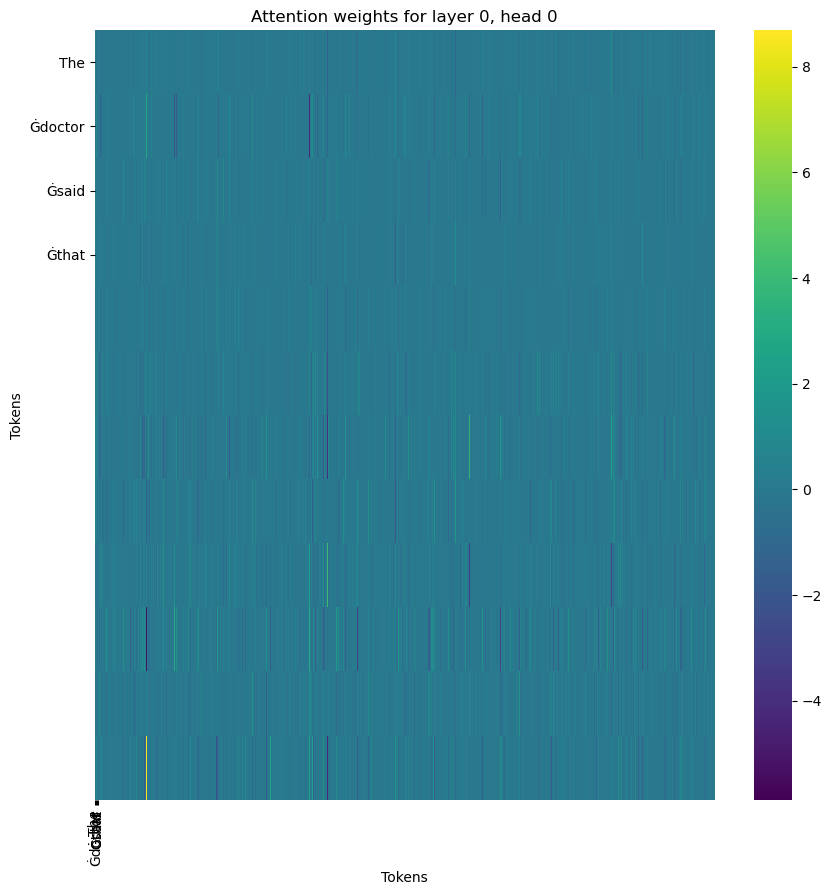

In [26]:
dm = AttentionDiffMask(config=config, device=get_device())
  
# 假设有一个批次的数据
originals = ["The doctor said that"]
counterfactuals = ["The nurse said that"]

mask = torch.ones((len(originals), dm.model.cfg.n_layers, dm.model.cfg.n_heads))

# 执行干预并获取注意力权重
dm.intervene(originals, counterfactuals, mask)

# 获取原始句子的 tokens
tokens = dm.model.tokenizer.tokenize(originals[0])

# 可视化第0层第0个注意力头的权重
visualize_attention(dm.attention_weights, layer=0, head=0, sentence=originals[0], tokens=tokens)

In [27]:
tokens = dm.model.tokenizer.tokenize(originals[0])
print("Tokens:", tokens)


Tokens: ['The', 'Ġdoctor', 'Ġsaid', 'Ġthat']


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
def prune_attention_weights(attention_weights, threshold=0.1):
    pruned_attention_weights = []
    for layer_weights in attention_weights:
        pruned_layer_weights = []
        for head_weights in layer_weights:
            pruned_head_weights = head_weights * (head_weights > threshold)
            pruned_layer_weights.append(pruned_head_weights)
        pruned_attention_weights.append(pruned_layer_weights)
    return pruned_attention_weights

pruned_attention_weights = prune_attention_weights(dm.attention_weights, threshold=0.1)

def visualize_attention(attention_weights, layer, head, tokens, threshold=0.1):
    plt.figure(figsize=(10, 10))
    attention = attention_weights[layer][0, head, :, :].numpy()
    attention = attention * (attention > threshold)  # 仅显示高于阈值的权重
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Attention weights for layer {layer}, head {head}')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# 示例调用
tokens = ["The", "doctor", "said", "that"]
pruned_attention_weights = prune_attention_weights(dm.attention_weights, threshold=0.1)
visualize_attention(pruned_attention_weights, layer=0, head=0, tokens=tokens)


TypeError: list indices must be integers or slices, not tuple

<Figure size 1000x1000 with 0 Axes>